In [21]:
import arviz as az
import pandas as pd
import json

import numpy as np
import diffrax
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import sys
from scipy.stats import mode

jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.style.use('custom')

# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
sys.path.insert(0, '/home/nlinden/.matplotlib/')
from plotting_helper_funcs import *

# custom plotting helper funcs
sys.path.insert(0, '../')
from plotting_helper_funcs import *
from utils import *

rng = np.random.default_rng(seed=1234)

Now load in all of the posterior idata and the posterior predictive samples...

In [22]:
# Load in info about the models
model_info = json.load(open('../param_est/model_info.json'))
model_names = list(model_info.keys())
display_names = [model_info[model]['display_name'] for model in model_names]

# get data
inputs, data = load_data('../../../results/MAPK/HF_96_synthetic_data.csv')

# load trajectory data
inputs_traj, data_traj, data_std_traj, times_traj = load_data_json('../../../results/MAPK/HF_96_traj_data.json', data_std=True, time=True)
data_time_to_mins = 60

# set up a color palette
# this is the ColorBrewer purple-green with 11 colors + three greys https://colorbrewer2.org/#type=diverging&scheme=PRGn&n=11
# colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b','#363737','#929591','#d8dcd6']
# this one gets to 10 colors by removing the darkest purple
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#363737','#929591','#d8dcd6']
orange = '#de8f05'

#### Load the error and uncertainty data

In [23]:
savedir = '../../../results/MAPK/mmi/'

# Trained on dose response data - predict dose response
with open(savedir+'HF96_all_models_MMI_stats.json', 'r') as f:
        DR_training_DR_pred = json.load(f)

# Trained on dose response data - predict time course
with open(savedir+'HF96_synth_DR_pred_traj_stats.json', 'r') as f:
        DR_training_traj_pred = json.load(f)

# Trained on time course data - predict time course
with open(savedir+'HF96_traj_all_models_MMI_stats.json', 'r') as f:
        traj_training_traj_pred = json.load(f)

# Trained on time course data - predict dose response
with open(savedir+'HF96_traj_synth_pred_DR_stats.json', 'r') as f:
        traj_training_DR_pred = json.load(f)

In [41]:
np.squeeze(np.array(list(traj_training_DR_pred['credible_95'].values())))

array([0.66051812, 0.16593665, 0.12853242, 0.0414605 , 0.09915748,
       0.23894478, 0.51603452, 0.13752422, 0.40373837, 0.07938959,
       0.22997116, 0.13969207, 0.48190277])

#### Make barplots of the raw errors and uncertainties
*Note that we will compare errors and uncertainties for posterior samples NOT posterior predictive samples, because we do not have posterior predictive samples for the test data.*

Make grouped bar plots with training versus testing

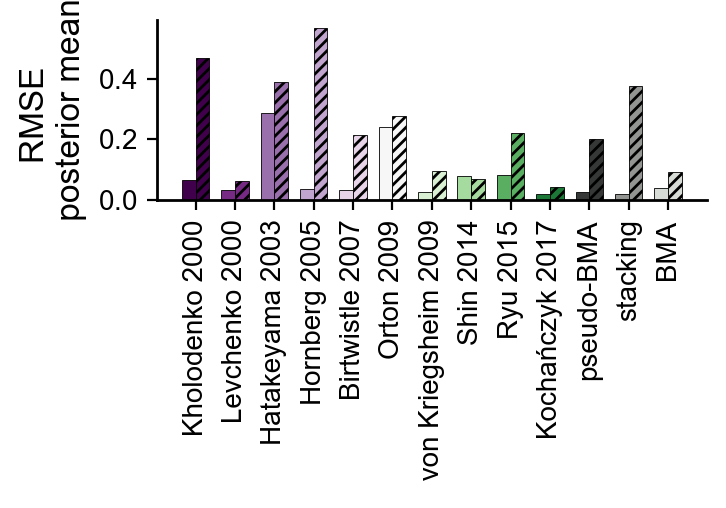

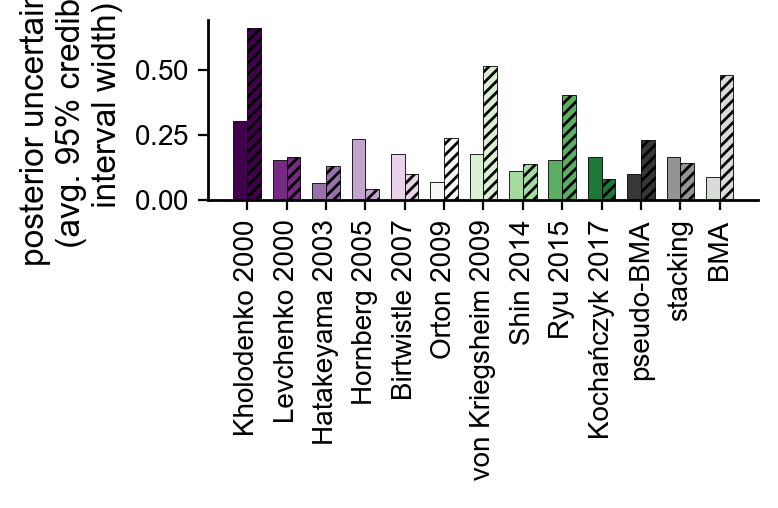

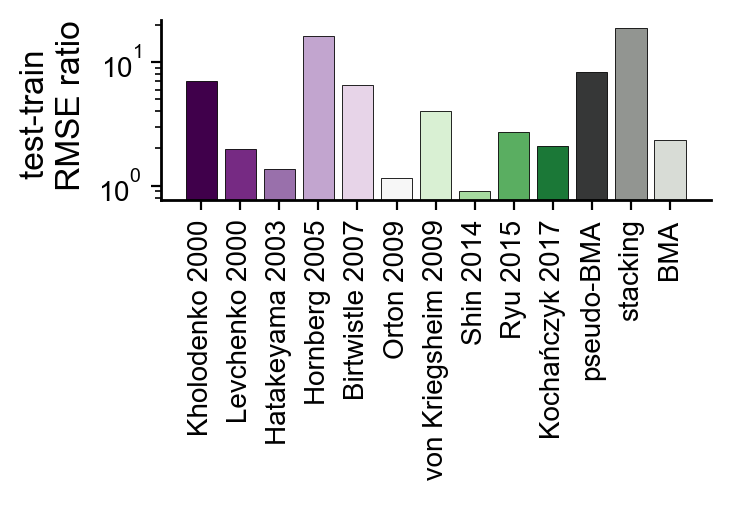

In [69]:
# Dose response preds

# RMSE
fig, ax = get_sized_fig_ax(2.75, 0.9)
x = np.arange(len(DR_training_DR_pred['RMSE']['post']))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

for dat, name, hatch in zip([DR_training_DR_pred['RMSE']['post'], np.squeeze(np.array(list(traj_training_DR_pred['RMSE'].values())))], 
                          ['Train on DR', 'Train on traj'], [None, '//////']):
    offset = width * multiplier
    bar = ax.bar(x + offset, dat, width, label=None, edgecolor='k', hatch=hatch)
    for i, br in enumerate(bar):
        br.set_facecolor(colors[i])
    multiplier += 1

ax.set_xticks(x + width / 2)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
ax.set_ylabel('RMSE \n posterior mean ', fontsize=12.0)

ax.bar(np.nan, np.nan, color='w', edgecolor='k', label='Train on dose-response', hatch=None)
ax.bar(np.nan, np.nan, color='w', edgecolor='k', label='Test on dose-response', hatch='//////')
leg = ax.legend(loc='upper center', fontsize=8.0, bbox_to_anchor=(0.5, 1.4), )
export_legend(leg, '../../../results/MAPK/mmi/HF96_DR_RMSE_train_test_compare_leg.pdf')
leg.remove()

fig.savefig('../../../results/MAPK/mmi/HF96_DR_RMSE_train_test_compare.pdf', transparent=True)

# Cred 95
fig, ax = get_sized_fig_ax(2.75, 0.9)
x = np.arange(len(DR_training_DR_pred['credible_95']['post']))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

for dat, name, hatch in zip([DR_training_DR_pred['credible_95']['post'], np.squeeze(np.array(list(traj_training_DR_pred['credible_95'].values())))], 
                          ['Train on DR', 'Train on traj'], [None, '//////']):
    offset = width * multiplier
    bar = ax.bar(x + offset, dat, width, label=None, edgecolor='k', hatch=hatch)
    for i, br in enumerate(bar):
        br.set_facecolor(colors[i])
    multiplier += 1

ax.set_xticks(x + width / 2)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
ax.set_ylabel('posterior uncertainty \n (avg. 95% credible \n interval width)', fontsize=12.0)

ax.bar(np.nan, np.nan, color='w', edgecolor='k', label='Train on dose-response', hatch=None)
ax.bar(np.nan, np.nan, color='w', edgecolor='k', label='Test on dose-response', hatch='//////')
# leg = ax.legend(loc='upper center', fontsize=8.0, bbox_to_anchor=(0.5, 1.4), )
# export_legend(leg, '../../../results/MAPK/mmi/HF96_DR_credible_train_test_compare_leg.pdf')
# leg.remove()

fig.savefig('../../../results/MAPK/mmi/HF96_DR_credible_95_train_test_compare.pdf', transparent=True)


# RMSE ratio
fig, ax = get_sized_fig_ax(2.75, 0.9)
x = np.arange(len(DR_training_DR_pred['RMSE']['post']))  # the label locations
width = 0.35  # the width of the bars

bar = ax.bar(x, np.squeeze(np.array(list(traj_training_DR_pred['RMSE'].values())))/np.array(DR_training_DR_pred['RMSE']['post']), 
            edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
ax.set_yscale('log')
ax.set_xticks(x)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
ax.set_ylabel('test-train \n RMSE ratio', fontsize=12.0)

fig.savefig('../../../results/MAPK/mmi/HF96_DR_RMSE_ratio_train_test_compare.pdf', transparent=True)


array([2.09969796e+02, 4.95799516e-01, 6.56710388e+00, 3.02896921e+03,
       3.02488874e-01, 2.61232734e-01, 5.62530008e-01, 7.55011916e-01,
       5.23207713e+01, 1.63518054e+00, 1.01914566e+01, 1.63520189e+00,
       6.49303425e+00])

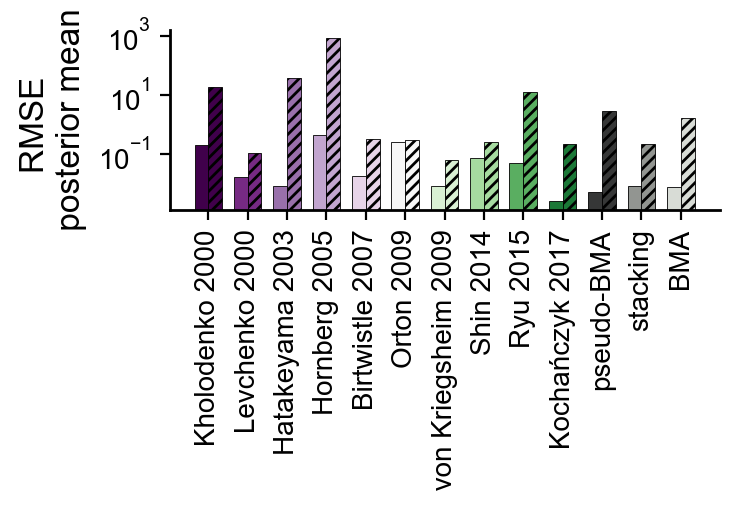

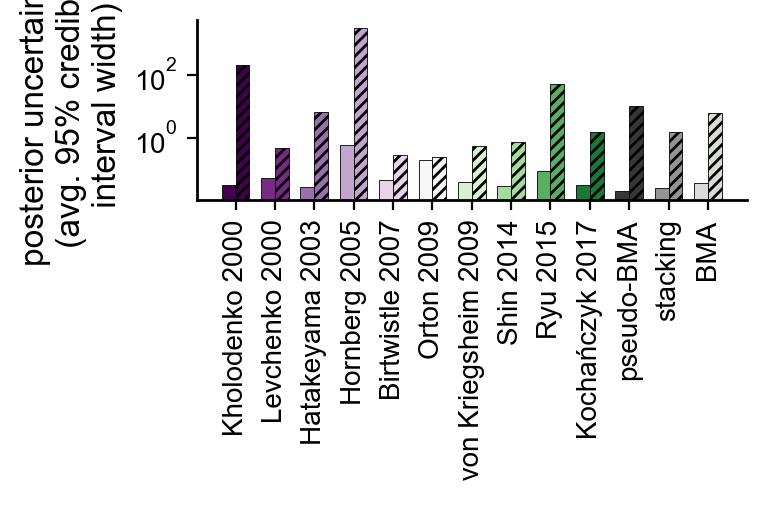

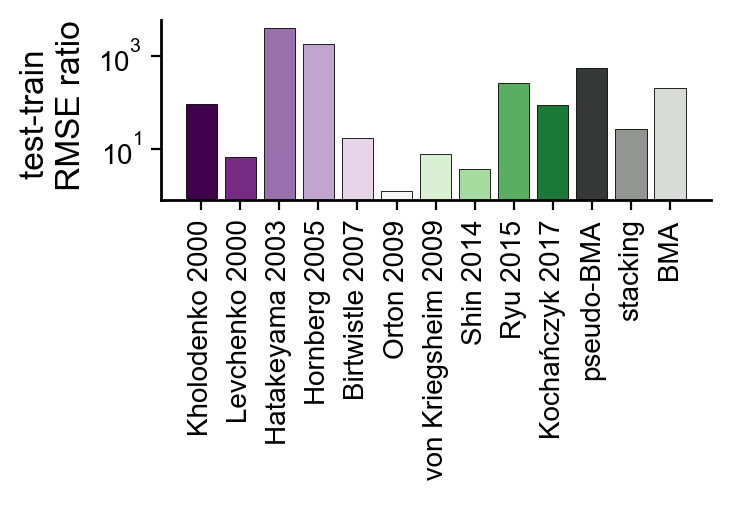

In [70]:
# traj preds

# RMSE
fig, ax = get_sized_fig_ax(2.75, 0.9)
x = np.arange(len(traj_training_traj_pred['RMSE']['post']))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

for dat, name, hatch in zip([np.mean(np.array(list(traj_training_traj_pred['RMSE']['post'].values())), axis=1),
                            np.mean(np.array(list(DR_training_traj_pred['RMSE'].values())),axis=1)], 
                          ['Train on traj', 'Test on traj'], [None, '//////']):
    offset = width * multiplier
    bar = ax.bar(x + offset, dat, width, label=None, edgecolor='k', hatch=hatch)
    for i, br in enumerate(bar):
        br.set_facecolor(colors[i])
    multiplier += 1
# ax.set_ylim(0, 2.5)
ax.set_yscale('log')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
ax.set_ylabel('RMSE \n posterior mean ', fontsize=12.0)

ax.bar(np.nan, np.nan, color='w', edgecolor='k', label='Train on trajectory', hatch=None)
ax.bar(np.nan, np.nan, color='w', edgecolor='k', label='Test on trajectory', hatch='//////')
leg = ax.legend(loc='upper center', fontsize=8.0, bbox_to_anchor=(0.5, 1.4), )
export_legend(leg, '../../../results/MAPK/mmi/HF96_traj_RMSE_train_test_compare_leg.pdf')
leg.remove()

fig.savefig('../../../results/MAPK/mmi/HF96_traj_RMSE_train_test_compare_leg.pdf', transparent=True)

# Cred 95
fig, ax = get_sized_fig_ax(2.75, 0.9)
x = np.arange(len(DR_training_DR_pred['credible_95']['post']))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

for dat, name, hatch in zip([np.mean(np.array(list(traj_training_traj_pred['credible_95']['post'].values())), axis=1),
                            np.mean(np.array(list(DR_training_traj_pred['credible_95'].values())),axis=1)],
                          ['Train on DR', 'Train on traj'], [None, '//////']):
    offset = width * multiplier
    bar = ax.bar(x + offset, dat, width, label=None, edgecolor='k', hatch=hatch)
    for i, br in enumerate(bar):
        br.set_facecolor(colors[i])
    multiplier += 1
# ax.set_ylim(0, 2.5)
ax.set_yscale('log')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
ax.set_ylabel('posterior uncertainty \n (avg. 95% credible \n interval width)', fontsize=12.0)

ax.bar(np.nan, np.nan, color='w', edgecolor='k', label='Train on trajectory', hatch=None)
ax.bar(np.nan, np.nan, color='w', edgecolor='k', label='Test on trajectory', hatch='//////')
# leg = ax.legend(loc='upper center', fontsize=8.0, bbox_to_anchor=(0.5, 1.4), )
# export_legend(leg, '../../../results/MAPK/mmi/HF96_DR_credible_train_test_compare_leg.pdf')
# leg.remove()

fig.savefig('../../../results/MAPK/mmi/HF96_traj_credible_95_train_test_compare_leg.pdf', transparent=True)

# RMSE ratio
fig, ax = get_sized_fig_ax(2.75, 0.9)
x = np.arange(len(DR_training_DR_pred['RMSE']['post']))  # the label locations
width = 0.35  # the width of the bars

bar = ax.bar(x, np.mean(np.array(list(DR_training_traj_pred['RMSE'].values())),axis=1)/np.mean(np.array(list(traj_training_traj_pred['RMSE']['post'].values())), axis=1), 
            edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
ax.set_yscale('log')
ax.set_xticks(x)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
ax.set_ylabel('test-train \n RMSE ratio', fontsize=12.0)

fig.savefig('../../../results/MAPK/mmi/HF96_traj_RMSE_ratio_train_test_compare_leg.pdf', transparent=True)